In [96]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

## PLOTTING GROUND TRUTH BOXES

In [97]:
gt_boxes = np.array([[133, 374, 110, 53],
                     [158, 26, 150, 124],
                     [9, 493, 131, 77],
                     [397, 63, 106, 57],
                     [304, 470, 171, 60],
                     [256, 176, 139, 169]])

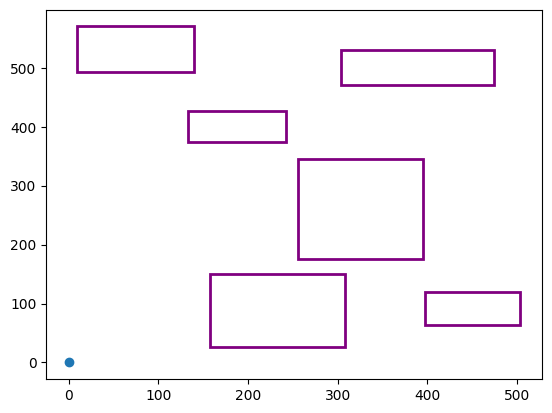

In [98]:
plt.scatter(0,0)

for box in gt_boxes:
  rect=mpatches.Rectangle(tuple(box[:2]), box[2], box[3], fill = False, color = "purple", linewidth = 2)
  plt.gca().add_patch(rect)

## PLOTTING PREDICTION BOXES WITHOUT NMS

In [99]:
pre_boxes = np.array([[140, 370, 119, 54, 0.95],
                      [368, 428, 187, 193, 0.94],
                      [146, 11, 152, 119, 0.92],
                      [310, 482, 161, 67, 0.91],
                      [23, 506, 133, 68, 0.88],
                      [19, 499, 130, 60, 0.85],
                      [416, 381, 133, 97, 0.85],
                      [387, 68, 107, 48, 0.83],
                      [20, 500, 125, 60, 0.82]])

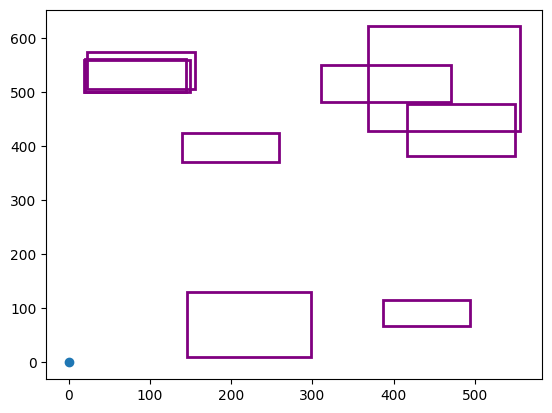

In [100]:
import matplotlib.patches as mpatches

plt.scatter(0,0)

for box in pre_boxes:
  rect=mpatches.Rectangle(tuple(box[:2]), box[2], box[3], fill = False, color = "purple", linewidth = 2)
  plt.gca().add_patch(rect)

There are multiple overlapping boxes => redundant info

## NMS

In [111]:
def box_iou(boxes_a, boxes_b):
    x1 = np.maximum(boxes_a[:, 0], boxes_b[:, 0])
    y1 = np.maximum(boxes_a[:, 1], boxes_b[:, 1])
    x2 = np.minimum(boxes_a[:, 0] + boxes_a[:, 2], boxes_b[:, 0] + boxes_b[:, 2])
    y2 = np.minimum(boxes_a[:, 1] + boxes_a[:, 3], boxes_b[:, 1] + boxes_b[:, 3])

    intersection = np.maximum(x2 - x1, 0) * np.maximum(y2 - y1, 0)
    area_a = boxes_a[:, 2] * boxes_a[:, 3]
    area_b = boxes_b[:, 2] * boxes_b[:, 3]
    union = area_a + area_b - intersection

    return intersection / union

def non_max_suppression(boxes, scores, threshold):
    if len(boxes) == 0:
        return []

    indices = np.argsort(scores)[::-1]

    selected_indices = []
    while len(indices) > 0:
        i = indices[0]
        selected_indices.append(i)

        iou = box_iou(boxes[i:i+1], boxes[indices[1:]])
        indices = np.delete(indices, 0)
        indices = np.delete(indices, np.where(iou > threshold)[0])

    return selected_indices

def apply_nms(predictions, iou_threshold=0.7):
    boxes = predictions[:, :4]
    scores = predictions[:, 4]
    selected_indices = non_max_suppression(boxes, scores, iou_threshold)
    return predictions[selected_indices]


## PLOTTING PREDICTION BOXES AFTER APPLYING NMS

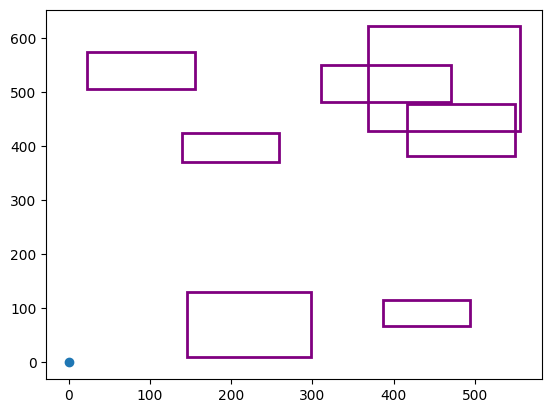

In [108]:
# Applying NMS to predicted boxes
nms_predictions = apply_nms(pre_boxes)

import matplotlib.patches as mpatches

plt.scatter(0,0)

for preds in nms_predictions:
  rect=mpatches.Rectangle(tuple(preds[:2]), preds[2], preds[3], fill = False, color = "purple", linewidth = 2)
  plt.gca().add_patch(rect)

## MAP using 11-point interpolation

In [109]:
# Predicted Bounding Boxes after NMS
nms_predictions = apply_nms(pre_boxes)

def box_iou(box_a, box_b):
    # Calculate intersection area
    x1 = max(box_a[0], box_b[0])
    y1 = max(box_a[1], box_b[1])
    x2 = min(box_a[0] + box_a[2], box_b[0] + box_b[2])
    y2 = min(box_a[1] + box_a[3], box_b[1] + box_b[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)

    # Calculate union area
    box_a_area = box_a[2] * box_a[3]
    box_b_area = box_b[2] * box_b[3]
    union_area = box_a_area + box_b_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area
    return iou

def precision_recall(gt_boxes, pred_boxes, iou_threshold):
    tp = 0
    fp = 0
    fn = len(gt_boxes)

    precision = []
    recall = []

    for pred_box in pred_boxes:
        max_iou = 0
        for gt_box in gt_boxes:
            iou = box_iou(gt_box, pred_box[:4])
            if iou > max_iou:
                max_iou = iou


        if max_iou >= iou_threshold:
            tp += 1
            fn -= 1
        else:

            fp += 1

        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))

    return precision, recall

def compute_ap(precision, recall):
    recall_levels = np.linspace(0, 1, 11)
    interpolated_precision = []

    for recall_level in recall_levels:
        precision_at_recall = 0
        for p, r in zip(precision, recall):
            if r >= recall_level:
                precision_at_recall = max(precision_at_recall, p)
        interpolated_precision.append(precision_at_recall)

    return np.mean(interpolated_precision)

# Calculate AP at different IoU thresholds
iou_thresholds = [0.2, 0.5, 0.8]
for threshold in iou_thresholds:
    precision, recall = precision_recall(gt_boxes, nms_predictions, threshold)
    ap = compute_ap(precision, recall)
    print(f"AP@{threshold}: {ap}")


AP@0.2: 0.6753246753246753
AP@0.5: 0.6753246753246753
AP@0.8: 0.0


## VISUALIZING TEST IMAGE

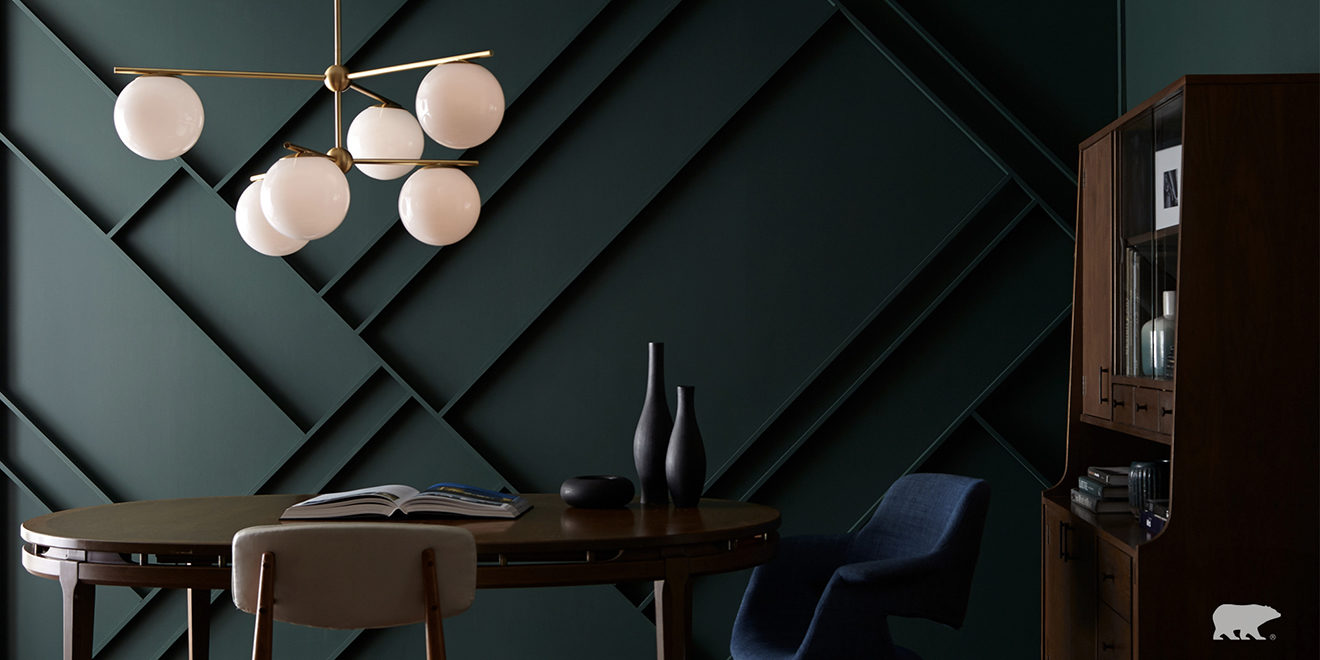

In [38]:
from IPython.display import display
from PIL import Image


display(Image.open("test.jpeg"))

## FasterRCNN

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


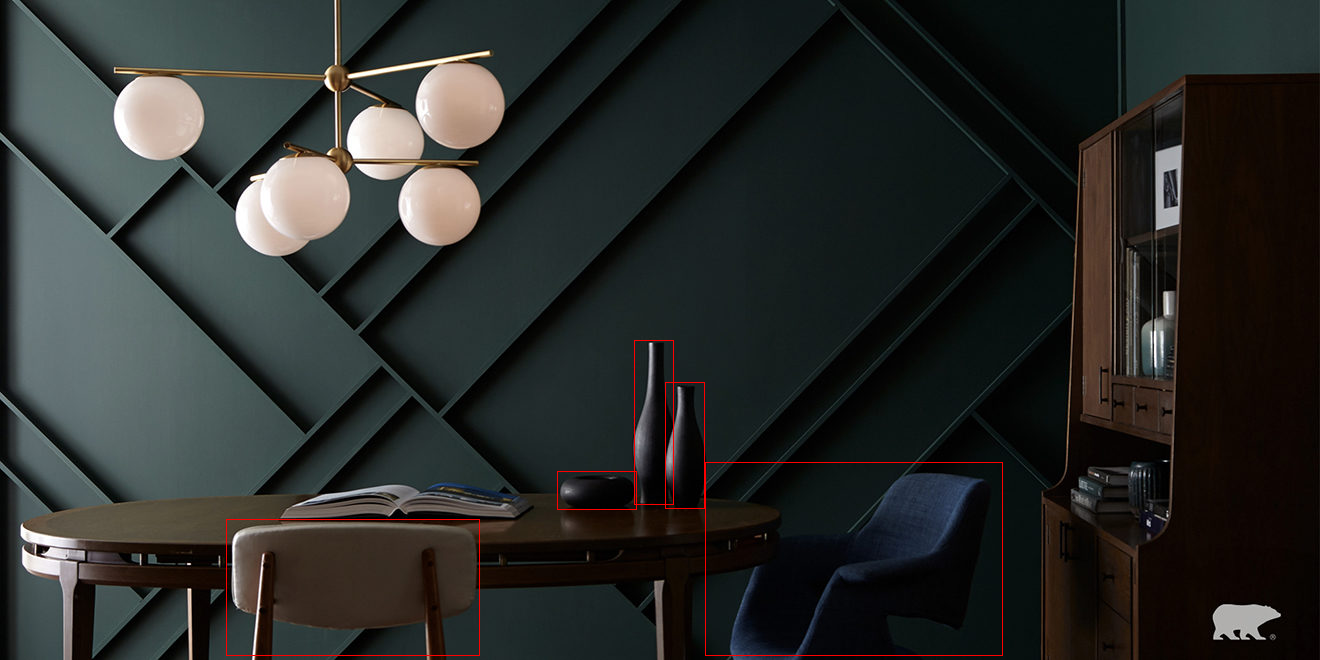

In [39]:
import torch
import torchvision
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from PIL import ImageDraw

# Load pre-trained Faster R-CNN model with ResNet50 backbone
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Set model to evaluation mode
model.eval()

# Define transformation to be applied to the input image
transform = T.Compose([T.ToTensor()])

# Load sample image
image = Image.open("test.jpeg")  # Replace "sample_image.jpg" with your image path

# Apply transformation to the image
input_image = transform(image)

# Convert image to batch tensor
input_image = input_image.unsqueeze(0)

# Perform inference
with torch.no_grad():
    prediction = model(input_image)

# Filter out predictions with score > 0.8
filtered_prediction = [{'boxes': pred['boxes'][pred['scores'] > 0.8], 'scores': pred['scores'][pred['scores'] > 0.8]} for pred in prediction]

# Draw bounding boxes on the image
result_image = image.copy()
draw = ImageDraw.Draw(result_image)
for pred in filtered_prediction:
    boxes = pred['boxes']
    for box in boxes:
        draw.rectangle(xy=[(box[0], box[1]), (box[2], box[3])], outline="red")

display(result_image)


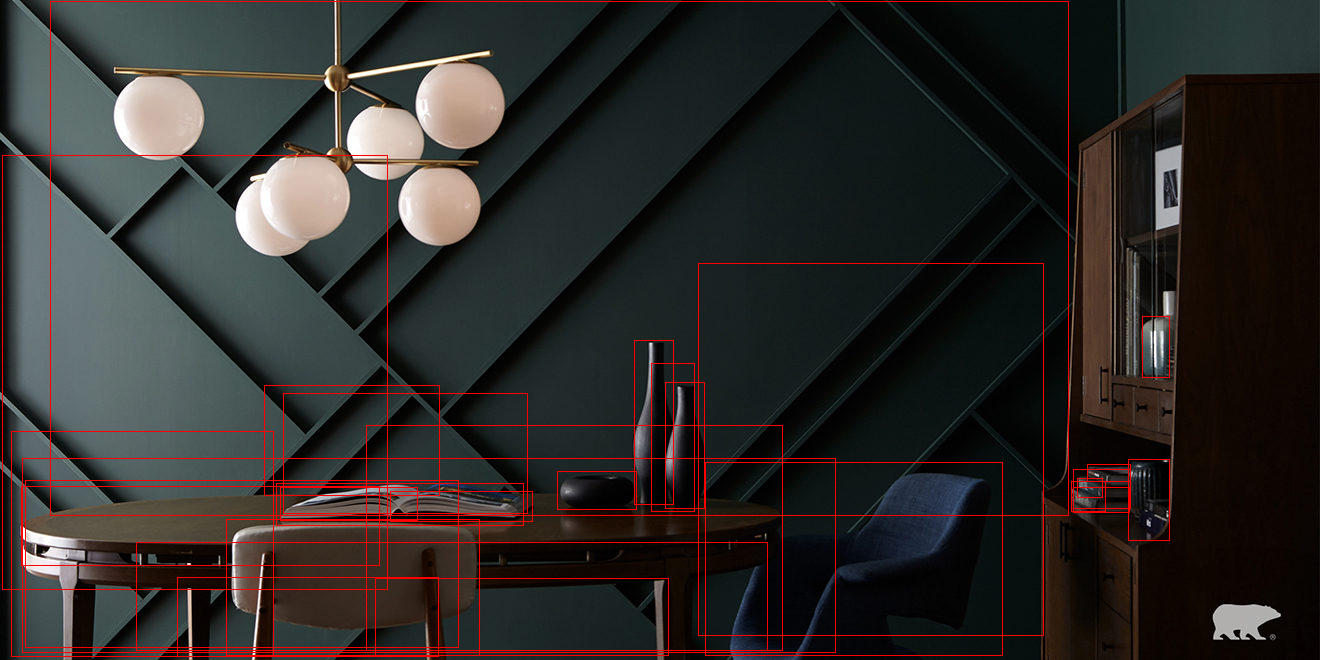

In [40]:
# Apply NMS to remove redundant bounding boxes
def apply_nms(prediction, iou_threshold=0.5):
    keep = torchvision.ops.nms(prediction['boxes'], prediction['scores'], iou_threshold)
    return {'boxes': prediction['boxes'][keep], 'scores': prediction['scores'][keep]}

# Apply NMS on all predictions with score > 0.2
filtered_prediction = [{'boxes': pred['boxes'], 'scores': pred['scores']} for pred in prediction]
nms_filtered_predictions = apply_nms(filtered_prediction[0])

# Draw bounding boxes after NMS on the image
result_image_nms = image.copy()
draw_nms = ImageDraw.Draw(result_image_nms)
for box in nms_filtered_predictions['boxes']:
    draw_nms.rectangle(xy=[(box[0], box[1]), (box[2], box[3])], outline="red")

display(result_image_nms)